## Report Topic 6: Density-based Clustering
The following notebook contains Python code for Topic 1: Density-based clustering and Topic 2: K-means Clustering.
**Density-based clustering** techniques, notably DBSCAN (Density-Based Spatial Clustering of Applications with Noise), identify clusters as contiguous regions of high point density, separated by areas of lower density. Within this framework, DBSCAN categorizes data points into core points, border points, and noise points, based on the density characteristics of their local neighborhoods. This approach allows for the discovery of clusters with arbitrary shapes and the identification of outliers.

We begin by importing the standard libraries

In [2]:
# Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN, KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score
from scipy.stats import gaussian_kde

# To avoid MKL memory warnings (KMeans)
os.environ["OMP_NUM_THREADS"] = "1"

### Loading and Preparing Data

**Dataset**: Colon Cancer Gene Expression (Alon et al.)
Reference link : https://www.inf.ed.ac.uk/teaching/courses/dme/html/datasets0405.html
####The colon cancer data
Description: This dataset is similar to the yeast gene expression dataset: it contains expression levels of 2000 genes taken in 62 different samples. For each sample it is indicated whether it came from a tumor biopsy or not. Numbers and descriptions for the different genes are also given. This dataset is used in many different research papers on gene expression data. It can be used in two ways: you can treat the 62 samples as records in a high-dimensional space, or you can treat the genes as records with 62 attributes.
Size:
2000 genes
62 samples
1.9 MB data, 529 KB names, 207 bytes labels
http://genomics-pubs.princeton.edu/oncology/affydata/index.html

In [3]:
# Loading the datasets
# I2000.txt → Expression Matrix
# names.txt → Gene descriptions (not used directly in clustering)
# tissue.txt → Labels

expression_data = pd.read_csv("I2000.txt", sep=r"\s+", header=None)
with open("names.txt", "r") as f:
    gene_names = [line.strip() for line in f.readlines()] # Loading gene names(text only)
tissue_labels = pd.read_csv("tissue.txt", header=None)    # Loading tissue labels
tissue_labels.columns = ['Tissue']                        

# Adding binary label: Tumor if negative sign, else Normal
tissue_labels['Label'] = tissue_labels['Tissue'].apply(lambda x: 'Tumor' if '-' in str(x) else 'Normal')

tissue_labels.head()

,Tissue,Label
0,-1,Tumor
1,1,Normal
2,-2,Tumor
3,2,Normal
4,-3,Tumor


### Data Preprocessing (*Transposing Data*)

In [4]:
# Transposing so that rows = samples, columns = genes
data = expression_data.T
data.columns = ["Gene_" + str(i) for i in range(data.shape[1])]

### STANDARDIZATION & PCA 
PCA for Dimensionality Reduction

In [5]:
# Standardize
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

# PCA 
pca = PCA(n_components=2)
pca_components = pca.fit_transform(scaled_data)
pca_df = pd.DataFrame(pca_components, columns=["PC1", "PC2"])
pca_df['True Label'] = tissue_labels['Label']

**K-Means** partitions the data into k clusters by minimizing intra-cluster variance. The optimal value of k was chosen using the Elbow Method, plotting SSE (sum of squared errors) and selecting the elbow point. Centroids of clusters were calculated and visualized in PCA space.

### Elbow Method (for KMeans k Estimation)

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Window

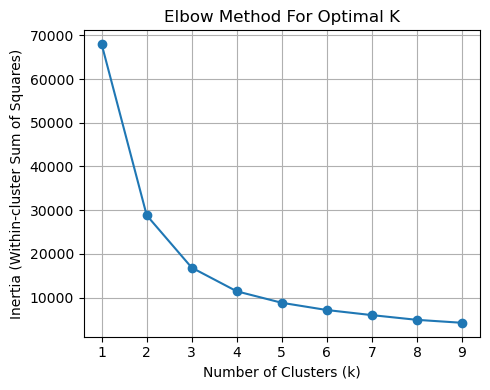

In [6]:
# Finding the number of clusters
inertias = []
K_range = range(1, 10)
for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(pca_components)
    inertias.append(km.inertia_)

# Plot Elbow Curve
plt.figure(figsize=(5, 4))
plt.plot(K_range, inertias, marker='o')
plt.title("Elbow Method For Optimal K")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia (Within-cluster Sum of Squares)")
plt.grid(True)
plt.tight_layout()
plt.show()

### Clustering (DBSCAN & KMeans)

In [7]:
#  Final clustering

# DBSCAN
dbscan = DBSCAN(eps=2, min_samples=5)
dbscan_labels = dbscan.fit_predict(pca_components)
pca_df['DBSCAN Cluster'] = dbscan_labels

# KMeans with optimal k = 2 (based on elbow and domain knowledge)
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(pca_components)
pca_df['KMeans Cluster'] = kmeans_labels
kmeans_centers = kmeans.cluster_centers_

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


### Density Estimation (DENCLUE-Inspired)

In [8]:
# ----------------- [6] DENSITY ESTIMATION (DENCLUE Inspired) -----------------
kde = gaussian_kde(pca_components.T)
pca_df['Density'] = kde(pca_components.T)

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Window

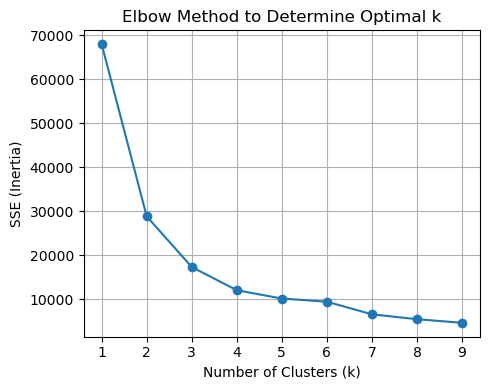

In [9]:
# List of cluster counts to test
num_clusters = range(1, 10)
sse = []

# Fit KMeans for each k and store SSE (inertia)
for k in num_clusters:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(pca_components)  # Use PCA-reduced data
    sse.append(kmeans.inertia_)

# Plot SSE vs Number of Clusters
plt.figure(figsize=(5, 4))
plt.plot(num_clusters, sse, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("SSE (Inertia)")
plt.title("Elbow Method to Determine Optimal k")
plt.grid(True)
plt.tight_layout()
plt.show()

#### Silhouette Scores for Comparison

In [10]:
# Silhouette Scores
dbscan_sil = silhouette_score(pca_components, dbscan_labels) if len(set(dbscan_labels)) > 1 else -1
kmeans_sil = silhouette_score(pca_components, kmeans_labels)

print(f"Silhouette Score - DBSCAN: {dbscan_sil:.3f}")
print(f"Silhouette Score - KMeans: {kmeans_sil:.3f}")

Silhouette Score - DBSCAN: -1.000
Silhouette Score - KMeans: 0.536


### Visualization Functions

In [11]:
# PCA View with True Labels
def plot_pca_true_labels(pca_df):
    plt.figure(figsize=(5, 4))
    sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="True Label", palette="coolwarm")
    plt.title("PCA: True Labels")
    plt.tight_layout()
    plt.savefig("pca_true_labels.png")
    plt.show()

In [12]:
# DBSCAN Plot with Custom Color for Noise
def plot_dbscan_clusters(pca_df):
    plt.figure(figsize=(5, 4))

    # Custom color map: assign gray to noise
    unique_clusters = sorted(pca_df["DBSCAN Cluster"].unique())
    palette = {cluster: ("gray" if cluster == -1 else sns.color_palette("Set2")[i])
               for i, cluster in enumerate(unique_clusters)}

    sns.scatterplot(
        data=pca_df, x="PC1", y="PC2",
        hue="DBSCAN Cluster", palette=palette
    )
    plt.title("DBSCAN Clustering (PCA View, Noise = Gray)")
    plt.tight_layout()
    plt.savefig("dbscan_clusters.png")
    plt.show()

*K-Means Clustering* with k=2 (optimal from Elbow Method) produced well-separated clusters, aligning reasonably with true labels (tumor vs normal)

In [13]:
# KMeans Plot with Centroids
def plot_kmeans_clusters(pca_df, kmeans_centers):
    plt.figure(figsize=(5, 4))
    sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="KMeans Cluster", palette="Set1")
    plt.scatter(kmeans_centers[:, 0], kmeans_centers[:, 1], c='black', marker='X', s=100, label='Centroids')
    plt.title("KMeans Clustering (PCA View, k=2)")
    plt.legend()
    plt.tight_layout()
    plt.savefig("kmeans_clusters.png")
    plt.show()

*DBSCAN* successfully identified core and noise points without needing k, and revealed local density patterns through KDE visualization.

In [14]:
# KDE Density Plot
def plot_kde_density(pca_df):
    plt.figure(figsize=(5, 4))
    plt.scatter(pca_df['PC1'], pca_df['PC2'], c=pca_df['Density'], cmap='viridis')
    plt.colorbar(label='Density')
    plt.title("Density Estimation (KDE)")
    plt.tight_layout()
    plt.savefig("kde_density.png")
    plt.show()

A k-distance graph helped tune eps for DBSCAN, and both methods were analyzed using PCA-reduced 2D views for interpretability.

In [16]:
# k-Distance Plot for DBSCAN
def plot_k_distance_graph(pca_components, k=5):
    knn = NearestNeighbors(n_neighbors=k)
    knn.fit(pca_components)
    distances, _ = knn.kneighbors(pca_components)
    k_distances = np.sort(distances[:, -1])
    plt.figure(figsize=(5, 4))
    plt.plot(k_distances)
    plt.title("k-Distance Plot (DBSCAN tuning aid)")
    plt.xlabel("Points sorted by distance")
    plt.ylabel(f"{k}th Nearest Neighbor Distance")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("k_distance_plot.png")
    plt.show()

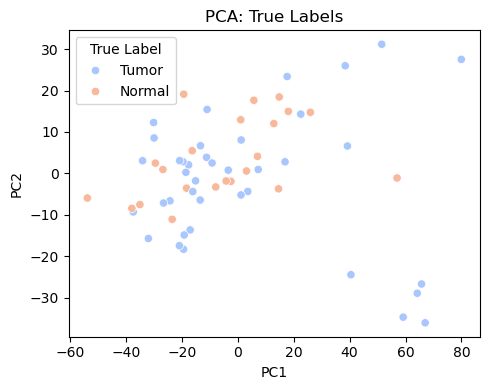

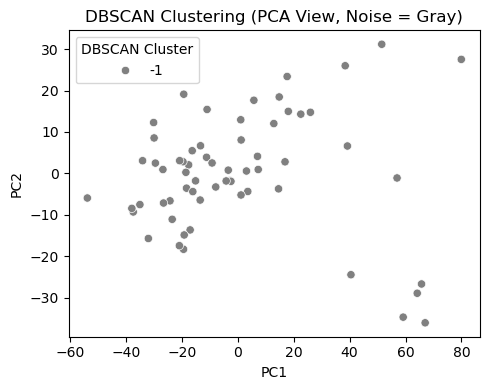

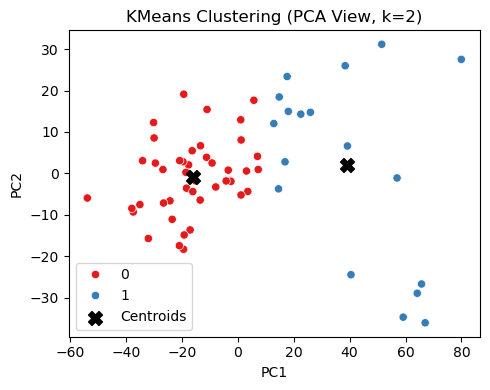

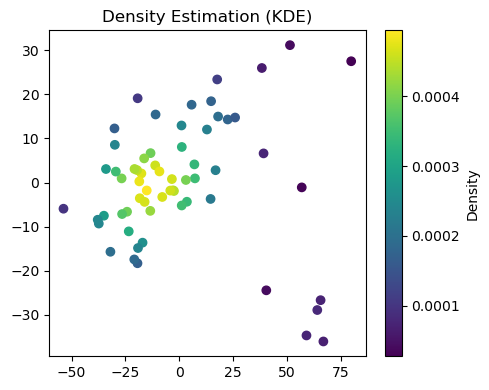

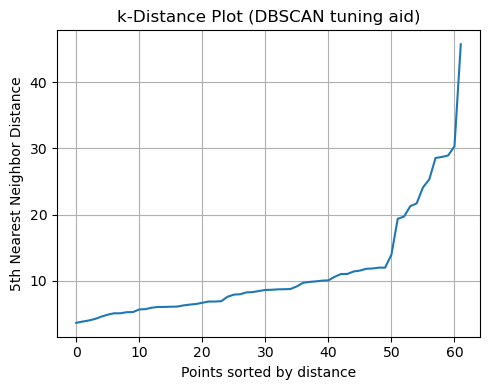

In [17]:
# Run All Visualizations
plot_pca_true_labels(pca_df)
plot_dbscan_clusters(pca_df)
plot_kmeans_clusters(pca_df, kmeans_centers)
plot_kde_density(pca_df)
plot_k_distance_graph(pca_components, k=5)

In [18]:
# Summary Table
summary = pd.DataFrame({
    "Method": ["DBSCAN", "KMeans"],
    "No. of Clusters": [len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0), len(set(kmeans_labels))],
    "Silhouette Score": [dbscan_sil, kmeans_sil]
})
print("\nSummary Table:")
print(summary)


Summary Table:
   Method  No. of Clusters  Silhouette Score
0  DBSCAN                0         -1.000000
1  KMeans                2          0.536095


#### Conclusion

Unlike centroid-based methods like KMeans, density-based clustering such as DBSCAN groups data based on local density rather than distance to a center. This allows it to detect arbitrarily shaped clusters and outliers, making it especially suitable for noisy, non-uniform datasets like gene expression profiles.
By comparing ** DBSCAN and K-Means**, we observed how assumptions about data shape, density, and distribution influence clustering outcomes.
DBSCAN offered flexibility in handling noise and arbitrarily shaped clusters, while K-Means required careful selection of cluster count but produced clean, compact groupings.

Beyond numerical evaluation, integrating visual interpretation, *density estimation (KDE)*, and g*raph-based insights (k-NN graph)* greatly enhanced our analytical perspective.
This notebook underscores the need for methodical experimentation, and thoughtful visual storytelling in effective data mining practice.